In [1]:
# Python 3 
import numpy as np 
import pandas as pd 

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))


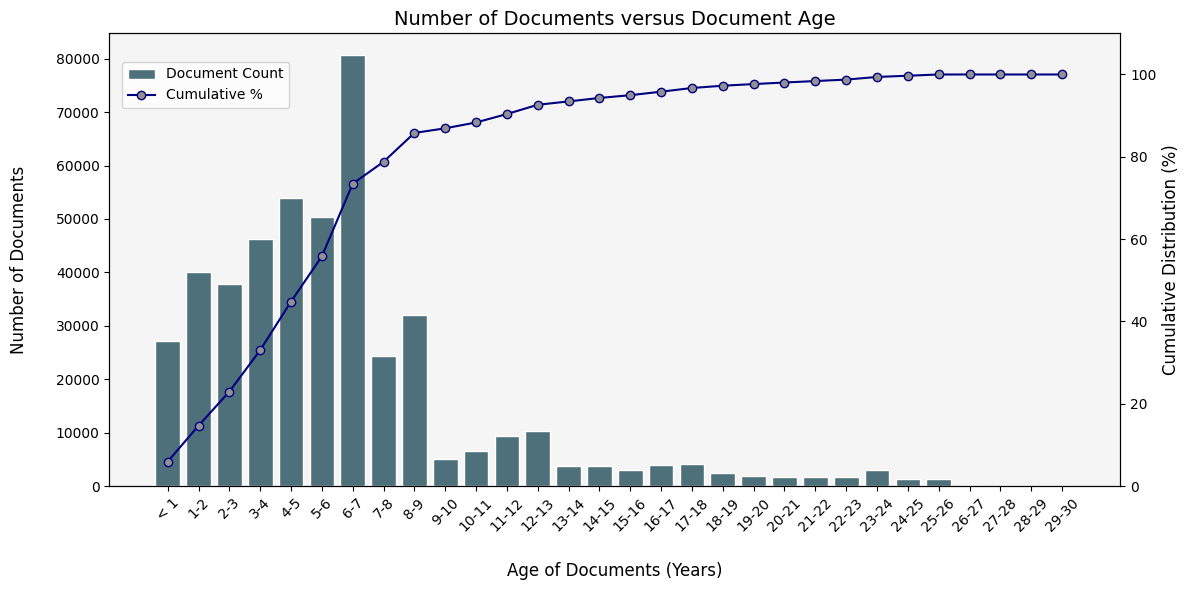

<Figure size 1500x800 with 0 Axes>

In [2]:
import matplotlib.pyplot as plt
import numpy as np


date_buckets = [ 
    "< 1", "1-2", "2-3", "3-4", "4-5", "5-6",
    "6-7", "7-8", "8-9", "9-10", "10-11", "11-12",
    "12-13", "13-14", "14-15", "15-16", "16-17", "17-18",
    "18-19", "19-20", "20-21", "21-22", "22-23", "23-24",
    "24-25", "25-26", "26-27", "27-28", "28-29", "29-30"
]  

num_documents = [
27145,39985,37880,46177,54001,50315,
80708,24434,32075,5153,6504,9357,
10299,3737,3845,3062,3909,4118,
2514,1851,1728,1629,1603,2938,
1381,1365,0,1,1,0
]




# Calculate cumulative distribution
cumulative_distribution = np.cumsum(num_documents)

# Normalize for percentage distribution
cumulative_distribution_percentage = (cumulative_distribution / cumulative_distribution[-1]) * 100

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for document count
color1 = '#4E707A'
ax1.bar(date_buckets, num_documents, color=color1, edgecolor='white', label='Document Count')
ax1.set_xlabel('Age of Documents (Years)', fontsize=12, labelpad=20)
ax1.set_ylabel('Number of Documents', fontsize=12, labelpad=20)
ax1.tick_params(axis='y', labelsize=10)
ax1.set_title('Number of Documents versus Document Age', fontsize=14)
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.set_facecolor('whitesmoke')


# Cumulative distribution line plot
color2 = '#919191'
ax2 = ax1.twinx()
ax2.plot(date_buckets, cumulative_distribution_percentage, color='navy', marker='o', markerfacecolor=color2, label='Cumulative %')
ax2.set_ylabel('Cumulative Distribution (%)', fontsize=12)
ax2.tick_params(axis='y', labelsize=10)
ax2.set_ylim(0, 110)

# Add legends for clarity
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), fontsize=10)

# Tight layout and show the plot
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,8))
plt.savefig('Fig-Document-Recency-Inventory.png', bbox_inches='tight')   
